In [168]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from pandas.tools.plotting import lag_plot
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import pystan

In [105]:
def month_string_to_number(string):
    """ month_string_to_number takes a month and turns it into the 
    corresponding number
    args:
        :string - each item is a string

    returns:
        :(out) - the equivalent of the month's number
    """
    m = {
        'jan': 1,
        'feb': 2,
        'mar': 3,
        'apr':4,
         'may':5,
         'jun':6,
         'jul':7,
         'aug':8,
         'sep':9,
         'oct':10,
         'nov':11,
         'dec':12
        }
    s = string.strip()[:3].lower()

    try:
        out = m[s]
        return out
    except:
        raise ValueError('Not a month')
        
path = '/Users/afugere/Desktop/UVM Masters/GraduateSemester2/STAT330/FinalProject/'
path2 = '/Users/abigailhotaling/Documents/STAT_330_Project/Data/'
data = pd.read_csv(path2+ 'Electricity_Residential_Price_New_England.csv')

#data.columns = ['Date', 'Electricity Residential Price: New England cents per kilowatthour']
data.columns = ['Date', 'Electricity Price']
# I also changed the column name for now, just to be a little bit shorter 
dates = []
months = []
years = []
for entry in data['Date']:
    dates.append(entry.replace('-', ' '))
    data['Month and Year'] = pd.Series(dates)
    months.append(month_string_to_number(str(entry[0:-3])))
    years.append(entry[-2:])
    data['Month'] = pd.Series(months)
    data['Year'] = pd.Series(years)
    
updated_years = []
for y in data['Year']:
    if int(y) > 19:
        updated_years.append('19'+y)
    else:
        updated_years.append('20'+y)
    data['Year'] = pd.Series(updated_years)
    
data['Day'] = [1]*len(data)

data['Datetime'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data.iloc[:] = data.iloc[::-1].values

In [106]:
def plot_trace(param, param_name='parameter'):
  """Plot the trace and posterior of a parameter."""
  
  # Summary statistics
  mean = np.mean(param)
  median = np.median(param)
  cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
  
  # Plotting
  plt.subplot(2,1,1)
  plt.plot(param)
  plt.xlabel('samples')
  plt.ylabel(param_name)
  plt.axhline(mean, color='r', lw=2, linestyle='--')
  plt.axhline(median, color='c', lw=2, linestyle='--')
  plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
  plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
  plt.title('Trace and Posterior Distribution for {}'.format(param_name))

  plt.subplot(2,1,2)
  plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
  plt.xlabel(param_name)
  plt.ylabel('density')
  plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
  plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
  plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
  plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
  plt.gcf().tight_layout()
  plt.legend()

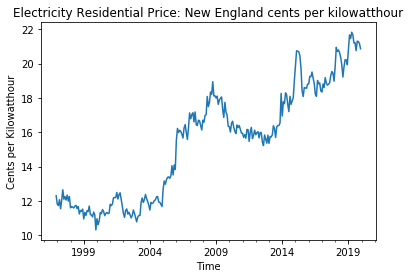

In [107]:
ax = data.plot(x = 'Datetime', y = 'Electricity Price', 
               title = 'Electricity Residential Price: New England cents per kilowatthour', legend = False)
ax.set_xlabel('Time')
ax.set_ylabel('Cents per Kilowatthour')
ax.format_xdata = mdates.DateFormatter('%Y-%m')

Model 1:

AR(2)

p=2 (number of lags)

$y_t = \alpha + \phi_1 y_{t-1} + \phi_2 y_{t-2}+\epsilon_t$

$\epsilon_t \sim N(0, \sigma^2)$

Need to estimate posterior for $\sigma^2$, $\phi_i$, $\alpha$ for $i=1, ...,2$ 

Priors: 

$\alpha \sim N(0, 1)$

$\phi_i \sim N(0, 1)$ for i in $i=1, ...,p$

$\sigma^2 \sim \Gamma^{-1}(a, b)$

Arbitrarily choose $a$ and $b$

Higher values of $b$ would give a wider distribution. And $a=b=1$ is an uniformitive prior. 

In [108]:
m1_stan_code = """
data {

    int T; // number of time steps
    int K; // Number of time series
    int P; // Number of lags for AR element
    
    matrix[T, K] Y; // data to model
        
    // priors
    real alpha_prior_location;
    real alpha_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
    
    real phi_prior_location;
    real phi_prior_scale;
    
}

transformed data{
    matrix[T,P] Y_lagged[K];
        
    for (k in 1:K){
        Y_lagged[k] = rep_matrix(0,T,P);
        for (p in 1:P){
            Y_lagged[k, p+1:T,p] = Y[1:T-p,k];
        }
    } 
}

parameters {
    vector[K] alpha; //intercept
    vector<lower=0>[K] sigma;
    matrix[K,P] phi; //lag parameters
}


model {
    matrix[T,K] err;
    matrix[T,K] nu;
    
    alpha ~ normal(alpha_prior_location, alpha_prior_scale);
    //sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    sigma ~ inv_gamma(sigma_prior_location, sigma_prior_scale);
    if (P>0){
    for (p in 1:P){
        phi[:,p] ~ normal(phi_prior_location, phi_prior_scale);
    }
    }
    
    
    for (k in 1:K) {
        nu[:,k] = rep_vector(alpha[k], T);
        if (P>0){
            nu[:,k] = nu[:,k] + Y_lagged[k]*phi[k]';
        }
    }
    
    err = Y - nu;
    
    for (k in 1:K){
        err[P+1:T,k] ~ normal(0, sigma[k]);
    }
}"""

In [109]:
m1_data = {'T':len(data), 'K':1, 'P':2, 'Y':np.asarray(list(data['Electricity Price'])).reshape(len(data), 1),
           "alpha_prior_location": 0, 'alpha_prior_scale':1, 'sigma_prior_location': 1, 'sigma_prior_scale':1, 
           'phi_prior_location':0, 'phi_prior_scale':1}


In [110]:
fit = pystan.stan(model_code=m1_stan_code, data=m1_data, iter=2000, warmup = 100, chains=3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_29faab67f95b545bed2e8a33d36fba9d NOW.


In [111]:
print(fit)

Inference for Stan model: anon_model_29faab67f95b545bed2e8a33d36fba9d.
3 chains, each with iter=2000; warmup=100; thin=1; 
post-warmup draws per chain=1900, total post-warmup draws=5700.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[1]   0.11  3.0e-3   0.12  -0.13   0.02    0.1   0.19   0.34   1688    1.0
sigma[1]   0.43  2.9e-4   0.02    0.4   0.42   0.43   0.45   0.47   4341    1.0
phi[1,1]   0.85  1.3e-3   0.06   0.73   0.81   0.84   0.89   0.96   2116    1.0
phi[1,2]   0.15  1.3e-3   0.06   0.03   0.11   0.15   0.19   0.27   2121    1.0
lp__      92.36    0.03   1.39  88.76  91.67  92.66  93.38  94.12   2057    1.0

Samples were drawn using NUTS at Wed Nov 21 09:57:52 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


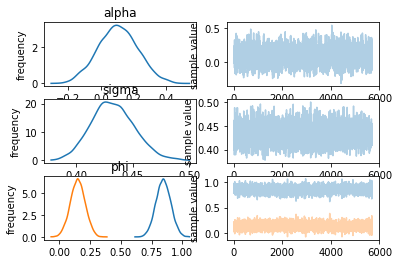

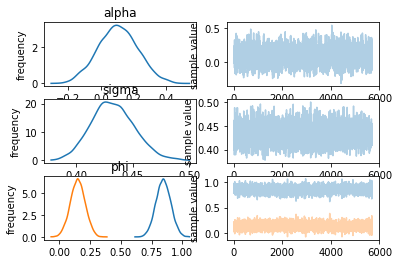

In [112]:
fit.plot()


In [113]:
summary_dic = fit.summary()
df = pd.DataFrame(summary_dic['summary'], columns = summary_dic['summary_colnames'], index=summary_dic['summary_rownames'])

In [114]:
df

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha[1],0.105501,0.002962,0.121693,-0.131232,0.020925,0.104158,0.188751,0.344912,1687.839894,1.000999
sigma[1],0.432444,0.000287,0.018903,0.397783,0.419378,0.431600,0.445003,0.470992,4340.597959,0.999620
"phi[1,1]",0.845543,0.001306,0.060092,0.728677,0.805428,0.844978,0.886401,0.963654,2115.834585,1.000086
"phi[1,2]",0.150075,0.001308,0.060220,0.032294,0.109411,0.150219,0.190403,0.266968,2120.745606,1.000156
lp__,92.356914,0.030710,1.392902,88.756042,91.671895,92.663422,93.381940,94.121164,2057.284165,1.002214


In [115]:
alpha_mean, sigma_mean, df_phi_0_0_mean, df_phi_0_1_mean = df['mean']['alpha[1]'], df['mean']['sigma[1]'], df['mean']['phi[1,1]'], df['mean']['phi[1,2]']

In [116]:
alpha = fit['alpha']
sigma = fit['sigma']
phi1 = [fit['phi'][i][0][0] for i in range(len(sigma))]
phi2 = [fit['phi'][i][0][1] for i in range(len(sigma))]
lp = fit['lp__']

### Alternative way to Look at the Trace Plots

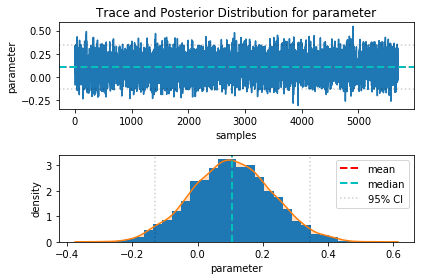

In [117]:
plot_trace(alpha)

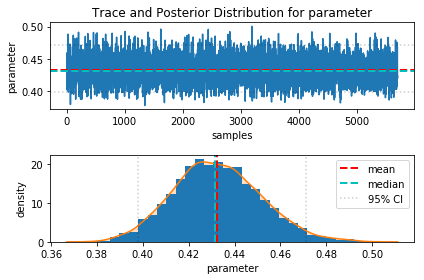

In [118]:
plot_trace(sigma)

/Users/abigailhotaling/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/abigailhotaling/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


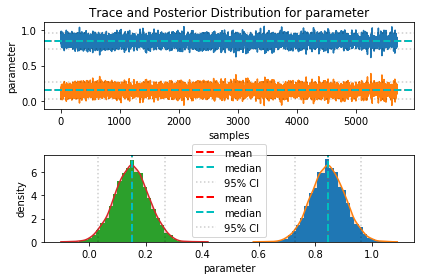

In [119]:
## I can't get this to work for phi
plot_trace(phi1)
plot_trace(phi2)

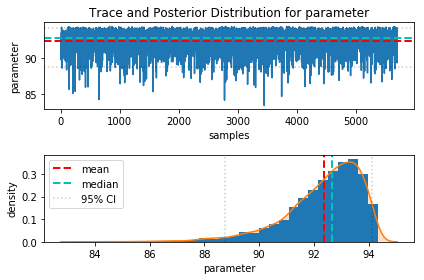

In [120]:
plot_trace(lp)

We seem to have convergence 

[Abby to-do]

    Need to look at these results compared to frequentist methods

    Look at residuals and model diagnostics
    
    Explore different priors
   
    


Model 1:

AR(2)

p=2 (number of lags)

$y_t = \alpha + \phi_1 y_{t-1} + \phi_2 y_{t-2}+\epsilon_t$

$\epsilon_t \sim N(0, \sigma^2)$


In [126]:
alpha_hat = df['mean'][0]
sigma_hat = df['mean'][1]
phi1_hat = df['mean'][2]
phi2_hat = df['mean'][3]

In [162]:
y_hat = []
n = len(data['Electricity Price'])
y = list(data['Electricity Price'])
for t in range(n):
    if t > 1:
        #y_hat.append(alpha_hat+phi1_hat*y[t-1] + phi2_hat*y[t-2]+np.random.normal(0, sigma_hat))
        y_hat.append(alpha_hat+phi1_hat*y[t-1] + phi2_hat*y[t-2])
        # confused about the error term

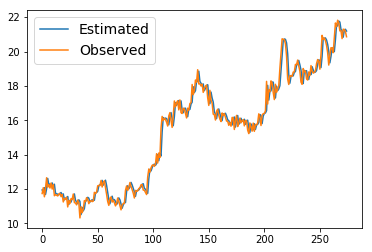

In [163]:
fig, ax = plt.subplots()
ax.plot(y_hat, label = 'Estimated')
ax.plot(y[2:], label = 'Observed')
ax.legend(loc='best', fontsize = 14)


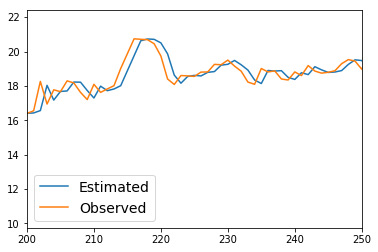

In [164]:
fig, ax = plt.subplots()
ax.plot(y_hat, label = 'Estimated')
ax.plot(y[2:], label = 'Observed')
ax.set_xlim(200,250)
ax.legend(loc='best', fontsize = 14)


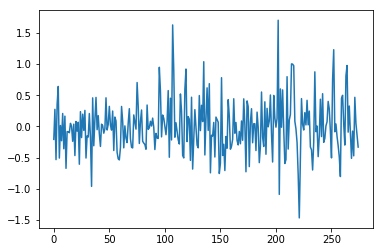

In [166]:
residuals = [obs-exp for obs,exp in zip(y[2:], y_hat)]
plt.plot(residuals)

/Users/abigailhotaling/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


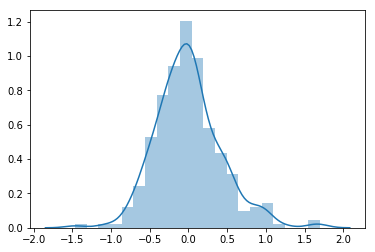

In [169]:
sns.distplot(residuals)

Questions:

    What is the log-likelihood of the model?
        Is that the lp__ from the stan output? 
        
    Need to compute some AIC/BIC values